# Kaggle: Toxic Comment Classification Challenge

## Import library

In [24]:
import sys
import os
import re
import csv
import codecs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

import gensim


## Read & Check train, test data

In [2]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [8]:
len(train)

159571

In [9]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [10]:
test.tail()

,id,comment_text
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."
153163,ffffce3fb183ee80,""" \n :::Stop already. Your bullshit is not wel..."


In [11]:
len(test)

153164

* check null

In [12]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [13]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

-> no null columns

* check the number/rate of toxic flag in test data set

In [14]:
train.loc[:, 'toxic':'identity_hate'].apply(sum)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [15]:
train.loc[:, 'toxic':'identity_hate'].apply(np.mean)

toxic            0.095844
severe_toxic     0.009996
obscene          0.052948
threat           0.002996
insult           0.049364
identity_hate    0.008805
dtype: float64

-> very unbalanced data...

* check frequencies of tokens in each class

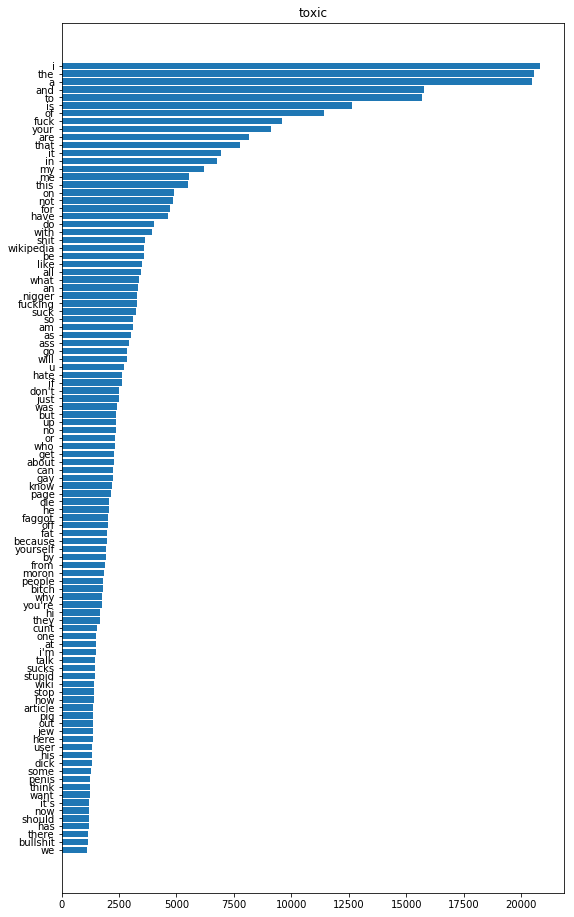

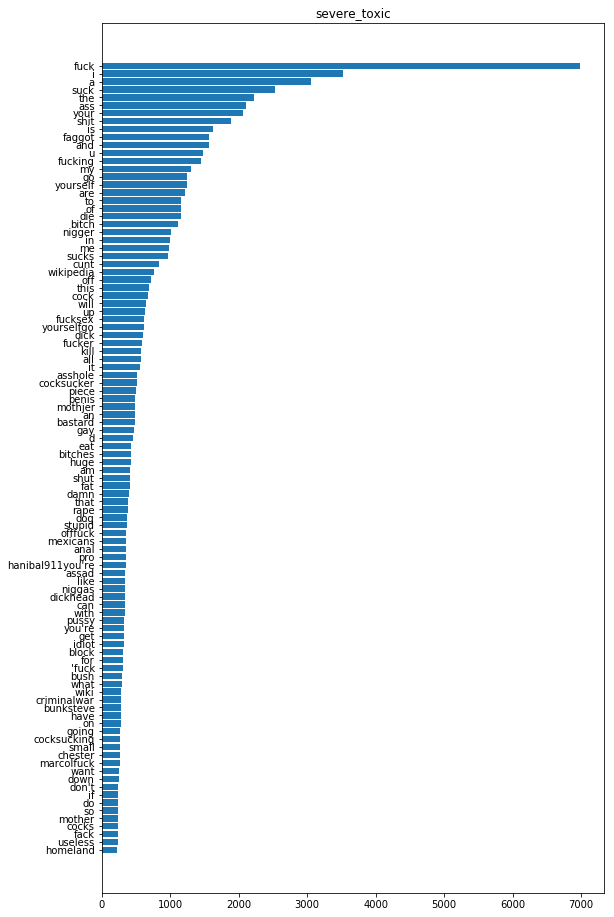

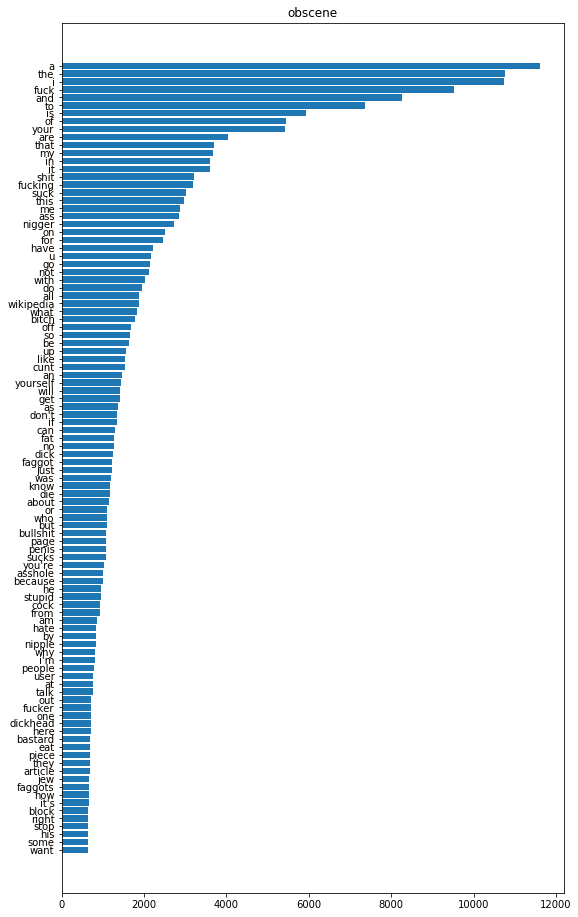

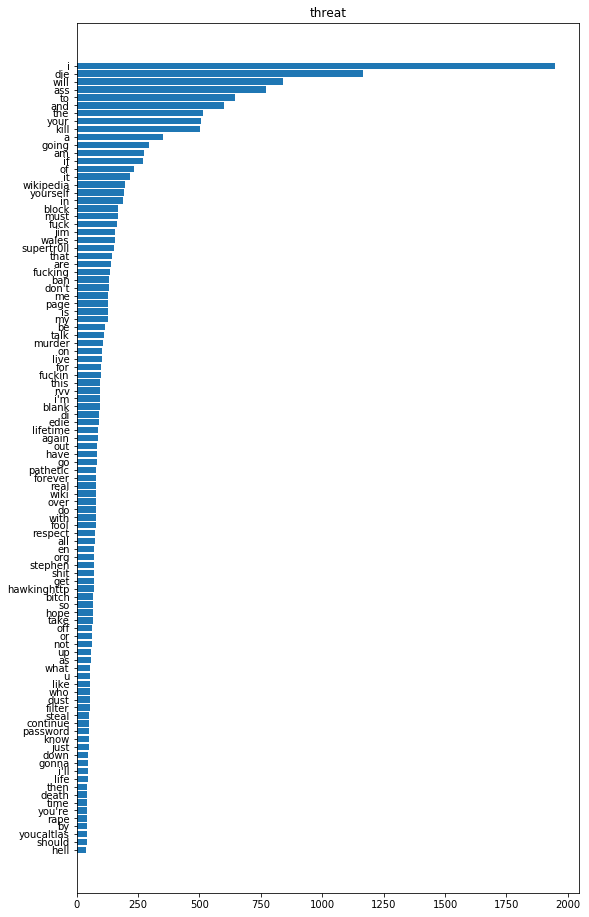

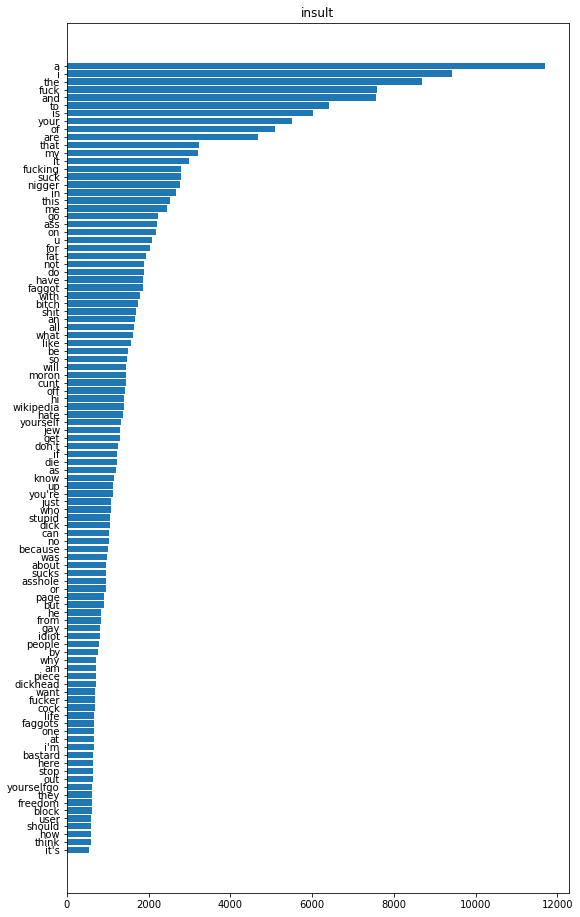

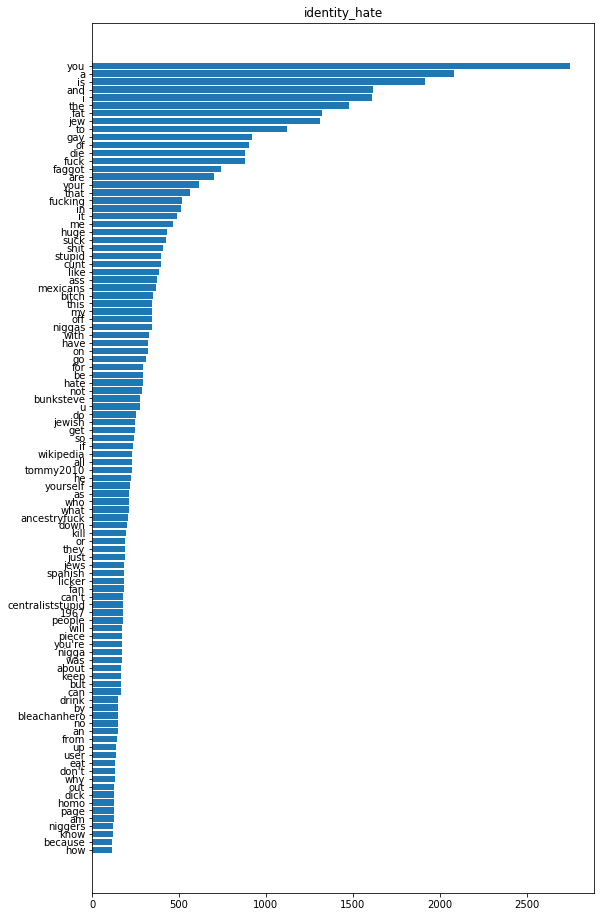

In [197]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
num_tokens = 20000
num_xcoord_words = 100

for word in list_classes:
    toxic_comment = train.query(word+'==1')['comment_text']
    tokenizer = Tokenizer(num_words=num_tokens)
    tokenizer.fit_on_texts(list(toxic_comment))
    token_toxic = sorted(tokenizer.word_counts.items(), key = lambda x: x[1], reverse=True)

    plt.figure(figsize=(9, 16))
    plt.title(word)
    plt.barh([token_toxic[num_xcoord_words-x][0] for x in range(num_xcoord_words)], 
             [token_toxic[num_xcoord_words-x][1] for x in range(num_xcoord_words)],)

-> most of the word is general -> model based on frequency without removing stop words won't work

## Preprocessing

* split data set to X(explanation variable), y(objective variable)

In [5]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

* tokenize

In [78]:
num_tokens = 20000
tokenizer = Tokenizer(num_words=num_tokens)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

-> no need to vectorise one-hot ? (proceeding with above data at first)

-> transform tokens to embedding matrix

* check the number of token for each sentense (train data) & padding (setting upper limit of the number of tokens)

In [20]:
num_words = [len(x) for x in list_tokenized_train]

(array([1.42259e+05, 1.19490e+04, 2.68600e+03, 1.12100e+03, 8.62000e+02,
        5.55000e+02, 9.20000e+01, 3.10000e+01, 1.20000e+01, 4.00000e+00]),
 array([   0.,  140.,  280.,  420.,  560.,  700.,  840.,  980., 1120.,
        1260., 1400.]),
 <a list of 10 Patch objects>)

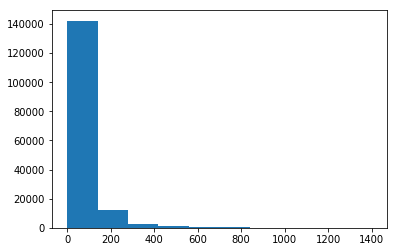

In [25]:
plt.hist(num_words)

(array([6.6717e+04, 3.9442e+04, 1.9385e+04, 1.0284e+04, 6.4310e+03,
        4.1910e+03, 3.0750e+03, 2.0940e+03, 1.4520e+03, 1.1370e+03,
        8.9900e+02, 6.1800e+02, 4.6000e+02, 3.8200e+02, 3.2700e+02,
        2.7200e+02, 2.4200e+02, 2.0400e+02, 2.0100e+02, 2.0200e+02,
        1.6700e+02, 1.7300e+02, 1.8900e+02, 1.6700e+02, 1.6600e+02,
        1.4400e+02, 1.2400e+02, 1.2500e+02, 9.8000e+01, 6.4000e+01,
        4.5000e+01, 2.1000e+01, 1.2000e+01, 9.0000e+00, 5.0000e+00,
        1.6000e+01, 3.0000e+00, 1.0000e+00, 6.0000e+00, 5.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00, 9.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([   0.,   28.,   56.,   84.,  112.,  140.,  168.,  196.,  224.,
         252.,  280.,  308.,  336.,  364.,  392.,  420.,  448.,  476.,
         504.,  532.,  560.,  588.,  616.,  644.,  672.,  700.,  728.,
         756.,  784.,  812.,  840.,  868.,  896.,  924.,  952.,  980.,
        1008., 1036., 1064., 1092.

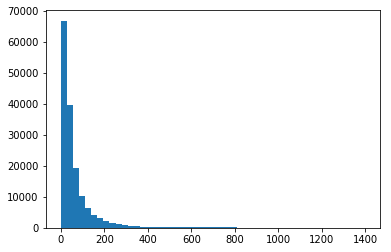

In [26]:
plt.hist(num_words, bins=50)

-> padding the number of tokens in a sentense @200

In [93]:
maxlen = 200
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

## Word embedding

In [92]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)embedding_dim = len(w2v_model.wv['apple'])
embedding_matrix = np.zeros((num_tokens, embedding_dim))
 
word_index = {v:k for k, v in tokenizer.word_index.items() if v < num_tokens}
for i, word in word_index.items():
    if word in w2v_model.wv.vocab:
        embedding_matrix[i] = w2v_model.wv[word]
embedding_layer = Embedding(num_tokens,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen) 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


## Modeling (making network)

In [94]:
embed_size = 128
lstm_output_dim = 60
dense_output_dim = 50

inputs = Input(shape=(maxlen, )) 
x = embedding_layer(inputs)
x = LSTM(lstm_output_dim, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(dense_output_dim, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

## Learning

In [95]:
batch_size = 32
epochs = 3
model.fit(X_train, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 1792s 12ms/step - loss: 0.0598 - acc: 0.9795 - val_loss: 0.0466 - val_acc: 0.9826
Epoch 2/3
143613/143613 [==============================] - 1780s 12ms/step - loss: 0.0412 - acc: 0.9841 - val_loss: 0.0469 - val_acc: 0.9833
Epoch 3/3
143613/143613 [==============================] - 1780s 12ms/step - loss: 0.0356 - acc: 0.9859 - val_loss: 0.0484 - val_acc: 0.9832


In [100]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 300)          6000000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           86640     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 60)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
__________

* Summary about input & output dimension, the number of parameter of each layer

    * embedding: 20000dim -> 128dim (for 200 sqquence) (param=20000*128)

    * LSTM 128dim -> 60dim (input->output), 60dim -> 60dim(hidden->hidden) (for output, forget, input sigmoid, input tanh gate)(param=(128*60+60(bias) + 60*60)*4)

    * Full Connection layer(Activation: relu) 60dim -> 50dim (param=60*50+50)

    * Full Connecton layer(Activation: sigmoid) 50dim -> 6dim (param=50*6+6)

## Inference & make submit data

In [96]:
pred = model.predict(X_test)

In [97]:
pred_output = pd.concat([test[['id']], pd.DataFrame(pred)], axis=1)
pred_output.columns = ['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
pred_output.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999525,2.256068e-01,0.990262,8.112506e-03,0.954711,1.924259e-01
1,0000247867823ef7,0.000036,3.430329e-08,0.000012,1.291085e-07,0.000003,1.512436e-06
2,00013b17ad220c46,0.000495,4.249434e-07,0.000117,1.053485e-06,0.000057,7.072745e-06
3,00017563c3f7919a,0.000026,3.335587e-08,0.000008,5.251870e-08,0.000002,9.269936e-07
4,00017695ad8997eb,0.001005,3.890165e-07,0.000079,2.038280e-06,0.000065,5.567051e-06


In [99]:
pred_output.to_csv('./output/submit_data.csv', index=False)